In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import data to workspace
DATA_PATH = "./datasets/aggregated_data.csv"

df1 = pd.read_csv(DATA_PATH)

# get heads of columns
info_draft = open("./info.txt", "w")
for head in df1.columns:
    info_draft.write(str(head))
    info_draft.write("\n")

info_draft.close()

plt.figure(dpi=4000)

<Figure size 25600x19200 with 0 Axes>

<Figure size 25600x19200 with 0 Axes>

首先我们来对数据进行一些预处理，排除掉一些无需分析的数据（比如报告的VIN码）
看一下和事故有关的这些数据的以下分布：
- 报错的公司（Make）
- 报错的月份（Report Submission Date）
- 使用的自动化模型的年份（Model Year）
- 里程数（Mileage）
- 报错的时间（Incident Time (24:00)）
- 行驶的路类型，高速还是小路（Roadway Type）
- 行驶的路况（Roadway Surface）
- 限速情况（Posted Speed Limit (MPH)）
- 光照情况（Lighting）
- 天气情况（Weather矩阵）
- 撞上的对象（Crash With）
- 撞上之前的自动操作（CP Pre-Crash Movement)
- 接触压力感知部位（CP Contact Area矩阵）
- 传感器导致的气囊释放情况（SV Any Air Bags Deployed?）
- 传感器撞上之前的速度（SV Precrash Speed (MPH)）
- 传感器接触区域（SV Contact Area 矩阵）

In [170]:
length = len(df1)
Make = df1.loc[:, "Make"]
Month = df1.loc[:, "Report Submission Date"]
ModelYear = df1.loc[:, "Model Year"]
# replace unknown mileage
# df1.loc[:, "Mileage"].fillna(-1, inplace=True)
Mile = df1.loc[:, "Mileage"]

InciTime = df1.loc[:, "Incident Time (24:00)"]
RoadType = df1.loc[:, "Roadway Type"]
RoadSurface = df1.loc[:, "Roadway Surface"]
SpeedLimit = df1.loc[:, "Posted Speed Limit (MPH)"]
Lighting = df1.loc[:, "Lighting"]
WeatherMatrix = df1.iloc[:, 57:66]
CrashWith = df1.loc[:, "Crash With"]

CPMove = df1.loc[:, "CP Pre-Crash Movement"]
CPContactArea = df1.iloc[:, 72:83]

CPAirBag = df1.loc[:, "CP Any Air Bags Deployed?"]
SVAirBag = df1.loc[:, "SV Any Air Bags Deployed?"]
SVSpeed = df1.loc[:, "SV Precrash Speed (MPH)"]
SVContactArea = df1.iloc[:, 89:100]


对于这一些数据，首先来分析一下一些的统计量的分布
- 报错单位的饼图
- 事故月份图
- 模型年图
- 行驶里程数分布图

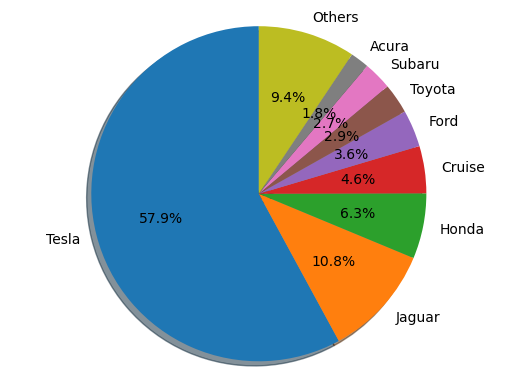

In [101]:
make_stats = Make.value_counts()

# print(list(make_stats[:]))
def draw_make_pie(make_val, length):
    x = list(make_val.keys()[0:8])
    x.append("Others")
    size = list(make_val[:])
    other_sum = 0
    for each in size[9:]:
        other_sum += each
    
    sumed_size = size[0:8]
    sumed_size.append(other_sum)
    # print(other_sum)

    y = [i/length for i in sumed_size]
    # print(len(x), len(y))

    fig1, ax1 = plt.subplots()
    ax1.pie(y, labels=x, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

draw_make_pie(make_stats, length)




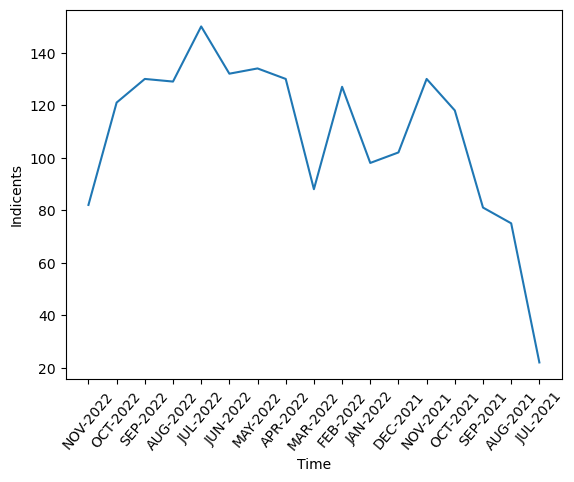

In [102]:
month_stats = Month.value_counts(sort=False)

def draw_month_bar(month_val):
    labels = list(month_val.keys())
    cnt = 0
    x = labels

    plt.figure(2000)
    
    y = list(month_val[:])
    plt.xlabel("Time")
    plt.ylabel("Indicents")
    plt.xticks(rotation=50)
    
    plt.plot(x,y)
    plt.show()

draw_month_bar(month_stats)

2014.0      6
2015.0     33
2016.0     96
2017.0     86
2018.0    167
2019.0    177
2020.0    408
2021.0    650
2022.0    214
2023.0      4
Name: Model Year, dtype: int64


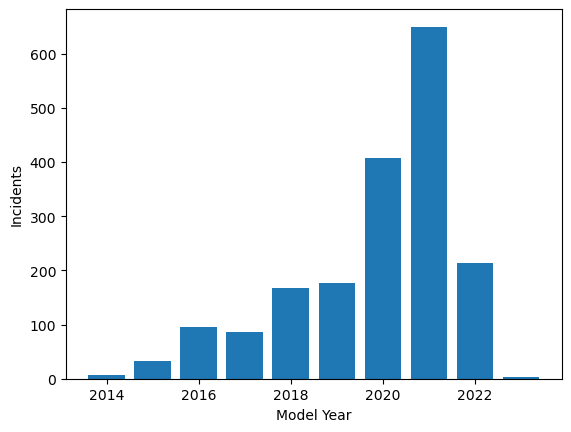

In [103]:
model_year_stats = ModelYear.value_counts(sort=False).sort_index()
print(model_year_stats)
def draw_age_fig(model_year):
    years = model_year.keys()
    values = model_year[:]

    bar_labels = years

    plt.bar(years, values, label = years)
    plt.xlabel("Model Year")
    plt.ylabel("Incidents")
    
    plt.show()

draw_age_fig(model_year_stats)



    

[Deprecated]对于里程数采用区间统计技术，把相应的里程数统计到以10k mile为间隔的单元当中
把里程数生成点图，画出平均里程数和10k里程数线
数据处理的时候需要去掉-1值，这样才能计算出准确的平均值

32068.646296296298


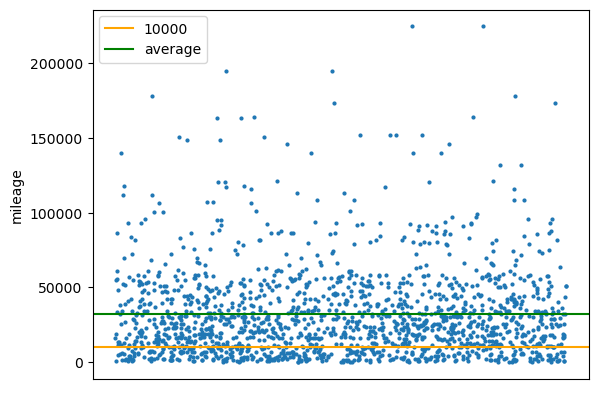

In [104]:
@DeprecationWarning
def draw_mile_bucket_fig(miledata):
    mile_bucket = [0,0,0,0,0,0,0,0,0,0,0]
    mileages = list(miledata[:])
    
    for mile in mileages:
        if mile < 0:
            continue
        mile_bucket[int(mile/10000) if mile/10000 < 10 else -1] += 1
    
    print(mile_bucket)

def draw_mile_dot_fig(miledata):
    mileages = list(miledata[:])
    known_mileages = []

    sum = 0
    cnt = 0
    for each in mileages:
        if each > 0 and each < 400000:
            sum += each
            cnt += 1
            known_mileages.append(each)
    average = sum / cnt
    print(average)
    range = np.random.uniform(0, 10, size=cnt)
    # print(range)
    plt.scatter(range, known_mileages, s=4)

    plt.axhline(y=10000,ls="-",c="orange", label="10000")
    plt.axhline(y=average,ls="-",c="green", label = "average")

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    plt.ylabel("mileage")

    plt.legend()
    plt.show()

draw_mile_dot_fig(Mile)


            


接下来我们做一些预备数据分析的处理，采用的是根因分析法，是一种定性分析的方法
需要进行相关度分析的有以下几个变量，由于需要进行协方差矩阵的计算，未知的值全部用均值替代：
数值变量，需要用聚类的方法来测定
- 里程数（Mileage）
- 报错的时间（Incident Time (24:00)）
- 限速情况（Posted Speed Limit (MPH)）
- 传感器撞上之前的速度（SV Precrash Speed (MPH)）

非数值变量
- 行驶的路类型，高速还是小路（Roadway Type）
- 行驶的路况（Roadway Surface）
- 光照情况（Lighting）
- 天气情况（Weather矩阵）
- 撞上的对象（Crash With）
- 撞上之前的自动操作（CP Pre-Crash Movement)
以下这两个数据采用矩阵的1范数类度量偏差值（降维）
- 接触压力感知部位（CP Contact Area矩阵）
- 传感器接触区域（SV Contact Area 矩阵）



In [105]:
mile_mean = Mile.mean()
Mile.fillna(mile_mean)
mile_data = Mile.to_numpy()

time_values = InciTime.to_numpy()
time_data = np.zeros(len(time_values), dtype=int)
cnt = 0
for time in time_values:
    if type(time) == str:
        if time[1] == ":":
            hour = int(time[0:1])
            minutes = int(time[2:4])
        else:
            hour = int(time[0:2])
            minutes = int(time[3:5])
        
        time_data[cnt] = hour*60+minutes
    else:
        time_data[cnt] = 12*60
    cnt += 1

def fill_mean(ori_data):
    mean = ori_data.mean()
    values = ori_data.to_numpy()
    data = np.zeros(len(values))
    cnt = 0
    for each in values:
        if str(each) == "nan":
            data[cnt] = mean
        else:
            data[cnt] = each
        cnt += 1
    return data

limit_data = fill_mean(SpeedLimit)
sv_data = fill_mean(SVSpeed)

print(sv_data)


[45.         73.         29.33711048 ... 18.         29.33711048
 29.33711048]


首先来对二元参数进行聚类处理

In [119]:
# True if overspeed
b_overspeed = []

for i in range(length):
    b_overspeed.append(True if sv_data[i] - limit_data[i] >= 0 else False)

def handle_airbag(Bag1, Bag2): 
    b_airbag = []
    for i in range(length):
        if type(Bag1[i]) == float or type(Bag2[i]) == float:
            b_airbag.append(True)
        elif Bag1[i][0] == "U" or Bag2[i][0] == "U":
            b_airbag.append(True)
        else:
            b_airbag.append(True if Bag1[i] == Bag2[i] else False)
    return b_airbag
# True if airbag detected and deployed
b_airbag = handle_airbag(CPAirBag, SVAirBag)

def handle_surface(surface):
    values = surface.to_numpy()
    ret = []
    known_dist = [True,True,True,True,True,True,True,True,False,False]
    for each in values:
        if type(each) == float:
            ret.append(np.random.choice(known_dist))
            continue
        if each[0] == "D":
            ret.append(True)
        elif each[0] == "U":
            ret.append(np.random.choice(known_dist))
        else:
            ret.append(False)
    return ret
# True if dry
b_dry_surface = handle_surface(RoadSurface)


        
        
        




print(SVSpeed.value_counts())

0.0     225
70.0     39
1.0      27
2.0      23
40.0     23
       ... 
90.0      1
97.0      1
81.0      1
37.0      1
86.0      1
Name: SV Precrash Speed (MPH), Length: 90, dtype: int64


以下用于聚类处理多元的参数

In [141]:
def handle_light(light):
    values = light.to_numpy()
    ret = []
    known_dist = [0,0,0,0,0,0,1,1,1,2]
    for each in values:
        if type(each) == float:
            ret.append(np.random.choice(known_dist))
            continue
        if each == "Daylight":
            ret.append(0)
        elif each[0] == "U":
            ret.append(np.random.choice(known_dist))
        elif each == "Dark - Not Lighted":
            ret.append(2)
        else:
            ret.append(1)
    return ret
# 0,1,2 refers to Daylight, Dark lighted and Dark not lighted
m_light3 = handle_light(Lighting)

def handle_speed(Speed, low, medium):
    values = Speed.to_numpy()
    ret = []
    res = [0,0,0]
    known_dist = [0,0,0,0,1,1,1,2]
    for each in values:
        if each == 0.0 or each == "nan":
            ret.append(np.random.choice(known_dist))
        elif each < low:
            ret.append(0)
            res[0] += 1
        elif each < medium:
            ret.append(1)
            res[1] += 1
        elif each < 1000:
            ret.append(2)
            res[2] += 1
        else:
            ret.append(np.random.choice(known_dist))
    # print(res)
    return ret
#0:Low speed, 1: Medium Speed, 2: High Speed
m_speed3 = handle_speed(SVSpeed, 35, 70)

def handle_roadtype(Road):
    values = Road.to_numpy()
    ret = []
    known_dist = [0,0,0,0,0,1,1,2,2,3]
    for each in values:
        if type(each) == float:
            ret.append(np.random.choice(known_dist))
            continue
        word = each[0]
        if word == "H":
            ret.append(0)
        elif word == "U":
            ret.append(np.random.choice(known_dist))
        elif word == "I":
            ret.append(1)
        elif word == "S":
            ret.append(2)
        else:
            ret.append(3)
    return ret
# 0: Highway, 1: Intersection, 2:Street, 3:Others
m_roadtype4 = handle_roadtype(RoadType)

def handle_move(Move):
    values = Move.to_numpy()
    ret = []
    dist = [0, 0, 0]
    known_dist = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2]
    for each in values:
        if type(each) == float:
            ret.append(np.random.choice(known_dist))
            continue
        if each == "Proceeding Straight":
            ret.append(0)
            dist[0] += 1
        elif each == "Unknown" or each == "Other, see Narrative":
            ret.append(np.random.choice(known_dist))
        elif each == "Stopped" or each == "Parked":
            ret.append(2)
            dist[2] += 1
        else:
            ret.append(1)
            dist[1] += 1
    return ret

# 0: Straight, 1: Turns or other moves, 2: Others
m_move3 = handle_move(CPMove)

def handle_crash(Crash):
    values = Crash.to_numpy()
    ret = []
    dist = [0, 0, 0]
    small_car = ["Passenger Car", "SUV", "Van"]
    big_car = ["Pickup Truck", "Heavy Truck", "Bus"]
    known_dist = [0,0,0,0,1,2,2,2]
    for each in values:
        if type(each) == float:
            ret.append(np.random.choice(known_dist))
            continue
        if each in small_car:
            ret.append(0)
            dist[0] += 1
        elif each == "Unknown" or each == "Other, see Narrative":
            ret.append(np.random.choice(known_dist))
        elif each in big_car:
            ret.append(1)
            dist[1] += 1
        else:
            ret.append(2)
            dist[2] += 1
    return ret

#0: small car, 1: big car, 2: others
m_crashwith3 = handle_crash(CrashWith)

def handle_mileage(Mile, low_age, mid_age):
    values = Mile.to_numpy()
    ret = []
    for each in values:
        if each <= low_age:
            ret.append(0)
        elif each <= mid_age:
            ret.append(1)
        else:
            ret.append(2)
    
    return ret

m_mileage3 = handle_mileage(Mile, 10000, 50000)

        

以下用于处理矩阵聚类

In [173]:
def handle_weather(Weather, weights):
    values = Weather.to_numpy()
    ret = []
    for each_line in values:
        line = []
        for entry in each_line:
            if entry == "Y":
                line.append(1)
            else:
                line.append(0)
        ret.append(line)
    
    n_info_mat = np.array(ret)
    n_weight_mat = np.array(weights).T
    # print(n_info_mat)
    # print(n_weight_mat.shape)
    res = np.dot(n_info_mat, n_weight_mat)
    # print(res)

    is_good_vec = []
    dist = [0, 0]
    known_dist = [True, True, True, True, True, True, True, True, True, False]
    for each in res:
        if each > 0:
            is_good_vec.append(True)
            dist[0] += 1
        elif each < 0:
            is_good_vec.append(False)
            dist[1] += 1
        else:
            is_good_vec.append(np.random.choice(known_dist))
    return is_good_vec

weather_weight = [10, -5, 2, -10, -10, -3, 0, 0, 0]
b_weather = handle_weather(WeatherMatrix, weather_weight)

def sensor_to_matrix(Sensor):
    values = Sensor.to_numpy()
    ret = []
    for each_line in values:
        line = []
        for entry in each_line:
            if entry == "Y":
                line.append(1)
            else:
                line.append(0)
        ret.append(line)
    
    return np.array(ret)

CPSensor = sensor_to_matrix(CPContactArea)
SVSensor = sensor_to_matrix(SVContactArea)

def manhatten(arr1, arr2):
    dis = 0
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            dis += 1
    return dis

def handle_sensor(sensor_mat1, sensor_mat2, thershold):
    ret = []
    for i in range(length):
        vec1 = sensor_mat1[i]
        vec2 = sensor_mat2[i]

        if manhatten(vec1, vec2) > thershold:
            ret.append(False)
        else:
            ret.append(True)
    
    return ret

b_sensor = handle_sensor(CPSensor, SVSensor, 2)
# print(b_sensor)



现在所有的准备工作接近完毕了，下面来实现根因分析的算法


In [241]:
search_mat = [     b_overspeed, 
                    b_dry_surface, 
                    b_airbag, 
                    b_sensor, 
                    b_weather,
                    m_light3,
                    m_speed3,
                    m_crashwith3,
                    m_mileage3,
                    m_move3,
                    m_roadtype4]

# list made of ((status, score))
result_unranked = []
class search_node:
    # search_mat: only include this layer and next ones
    # For example, depth = 1, only includes prev_mat[1:]
    # given_size: how many items remaining from pre-selectTree
    # given_iso: Sum of pre isolation powers
    # pre state: Result of pre-selectTree
    def __init__(self, search_mat, depth, given_size, given_iso, pre_state, iso_threshold = 0.89, size_thershold = 3):
        self.search_mat = search_mat
        self.layer = search_mat[0]
        self.depth = depth
        self.given_size = given_size
        self.given_iso = given_iso

        self.iso_threshold = iso_threshold
        self.size_threshold = size_thershold

        self.distri = []
        self.amount_distri = []

        self.typelist = [2,2,2,2,2,3,3,3,3,3,4]
        self.attr_type = self.typelist[self.depth]
        

        #use for slice search mat for next layer
        self.mat_for_slice = []
        for i in range(self.attr_type):
            self.mat_for_slice.append([])

        # Sliced mat for next layer
        self.sliced_mat = [] 

        self.pre_state = pre_state   


    
    def get_distribution(self):
        # Get the distribution first
        for i in range(self.attr_type):
            self.distri.append(0)

        # Only need to travel once through
        for i in range(self.given_size):
            self.distri[self.layer[i]] += 1
            self.mat_for_slice[self.layer[i]].append(i)
        
        for i in range(self.attr_type):
            self.amount_distri.append(self.distri[i])
            self.distri[i] /= self.given_size
        
    # Given distribution, calculate isolation_power, which means entropy loss in this case
    def iso_power(self):
        
        sum = 0
        for i in range(self.attr_type):
            temp = self.distri[i]
            if temp == 0 or temp == 1:
                return 0.5   
            sum -= temp*(np.log2(self.distri[i]))
        
        return sum

    # slice mat for next layer
    def slice_mat(self):

        for res_index in range(self.attr_type):
            index_mat = []
            for i in range(len(search_mat) - 1):
                layer = i + 1
                layer_temp = []
                for j in range(len(self.mat_for_slice[res_index])):
                    layer_temp.append(search_mat[layer][self.mat_for_slice[res_index][j]])
                index_mat.append(layer_temp)
            self.sliced_mat.append(index_mat)
        
        

    
    def succeed(self):
        if self.given_size <= self.size_threshold:
            return
        self.get_distribution()
        node_iso_power = self.iso_power()
        print("Searching ", self.pre_state)

        # reach the bottom of search tree
        if self.depth == 10:
            if node_iso_power >= self.iso_threshold:
                result_unranked.append((self.pre_state + [-1], self.given_iso))
            else:
                result_unranked.append((self.pre_state + [-1], self.given_iso))
                for i in range(self.attr_type):
                    result_unranked.append((self.pre_state + [i], self.given_iso + 1/node_iso_power))

            return
        # If this Node is A->B, but B cannot isolate, just change to A->C
        if node_iso_power >= self.iso_threshold:
            skip_level_node = search_node(search_mat[self.depth + 1:], self.depth + 1, self.given_size, self.given_iso + 1, self.pre_state + [-1])
            skip_level_node.succeed()

        # If this Node is A->B, and B has isolation, branch A->b1->C,..., A->bn->C, A->C
        else:
            skip_level_node = search_node(search_mat[self.depth + 1:], self.depth + 1, self.given_size, self.given_iso + 1, self.pre_state + [-1])
            skip_level_node.succeed()
            
            self.slice_mat()
            for i in range(self.attr_type):
                new_node = search_node(self.sliced_mat[i], self.depth + 1, self.amount_distri[i], self.given_iso + 1/node_iso_power, self.pre_state + [i])
                new_node.succeed()
        


In [242]:
begin_node = search_node(search_mat, 0, length, 0, [])
begin_node.succeed()




Searching  []
Searching  [-1]
Searching  [-1, -1]
Searching  [-1, -1, -1]
Searching  [-1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0]
Searching  [-1, -1, -1, -1, 0, -1]
Searching  [-1, -1, -1, -1, 0, -1, -1]
Searching  [-1, -1, -1, -1, 0, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0, -1, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0, 0]
Searching  [-1, -1, -1, -1, 0, 0, -1]
Searching  [-1, -1, -1, -1, 0, 0, -1, -1]
Searching  [-1, -1, -1, -1, 0, 0, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0, 0, -1, -1, -1, -1]
Searching  [-1, -1, -1, -1, 0, 0, 0]
Searching  [-1, -1, -1, -1, 0, 0, 0, -1]
Searching  [-1, -1, -1, -1, 0, 0, 0, -1, -1]
Searching  [-1, -1, -1, -1, 0, 0, 0, -1, -1, -1]
Searching  [-1, -1

/var/folders/0n/36gg_gw54h5cjl8_grwsrp400000gn/T/ipykernel_38615/1432177376.py:57: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  self.distri[self.layer[i]] += 1
/var/folders/0n/36gg_gw54h5cjl8_grwsrp400000gn/T/ipykernel_38615/1432177376.py:58: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  self.mat_for_slice[self.layer[i]].append(i)


Searching  [0, -1, 1, 1, 1, 0]
Searching  [0, -1, 1, 1, 1, 0, -1]
Searching  [0, -1, 1, 1, 1, 0, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, -1, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, -1, -1, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0]
Searching  [0, -1, 1, 1, 1, 0, 0, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, -1, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 0]
Searching  [0, -1, 1, 1, 1, 0, 0, 0, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 0, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 0, 1]
Searching  [0, -1, 1, 1, 1, 0, 0, 0, 1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 0, 1, 1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, -1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 0]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 0, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 0, 1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 1, -1]
Searching  [0, -1, 1, 1, 1, 0, 0, 1, 1, 0]
Searching  [0, -1,

In [247]:
# rank the combinations
result_ranked = sorted(result_unranked, key = lambda x:(x[1]))

print("Valid result: ", len(result_ranked))
print("Best result: ", result_ranked[len(result_ranked) - 1 - i])

Valid result:  15189
Best result:  ([1, -1, 1, 1, 1, 1, 1, 1, 1, 0, 3], 28.686613826612206)


In [218]:
# This is used for testing 
sea = [[1,2,3], [4,5,6], [7,8,9]]
wtemp = [[0,2], [1]]
wres = []

for res_index in range(len(wtemp)):
    index_mat = []
    for i in range(len(sea) - 1):
        layer = i + 1
        layer_temp = []
        for j in range(len(wtemp[res_index])):
            layer_temp.append(sea[layer][wtemp[res_index][j]])
        index_mat.append(layer_temp)
    wres.append(index_mat)
        

# for i in range(len(asd) - 1):
#     layer = i+1
#     woa = []
#     for j in range(len(temp)):
#         woaa = []
#         for k in range(len(temp[j])):
#             woaa.append(asd[layer][temp[j][k]])
#         woa.append(woaa)

#     res.append(woa)
print(wres)

[[[4, 6], [7, 9]], [[5], [8]]]
